In [1]:
from keras.preprocessing import image
import keras
from keras.layers import Dense, Lambda, Activation, Input, Concatenate
from keras.models import load_model, Sequential
from keras import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras.applications.inception_resnet_v2 import InceptionResNetV2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from training_wrapper.custom_layer import OntologyLayer

import matplotlib.pyplot as plt
import numpy as np
import os

C:\Anaconda3\envs\py27\lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
############################################################################################################################################

  warnings.warn(WARNING_MSG_GPU_ONLY % ('GPU-Specific', 'https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages'))
Using CNTK backend
C

In [2]:
def built_model(n_dishes, n_ingredients, n_concepts, ontology_file, weights_file):
    
    pre_trained = InceptionResNetV2(InceptionResNetV2(weights='imagenet', input_shape=(299,299,3)))
    x = pre_trained.get_layer('avg_pool').output

    outputs = []

    out_SL_1 = Dense(n_dishes)(x)
    out_ML_1 = Dense(n_ingredients)(x)

    outputs.append(out_SL_1)
    outputs.append(out_ML_1)

    x = Concatenate()(outputs)
    x = OntologyLayer((None,n_concepts), ontology_file, False)(x)
    
    out_SL_2 = Lambda( lambda x: x[:, :n_dishes])(x)
    out_ML_2 = Lambda( lambda x: x[:, n_dishes:])(x)
    
    outputs_list = []
    
    out_SL_act = Activation('softmax')(out_SL_2)
    out_ML_act = Activation('sigmoid')(out_ML_2)
    
    outputs_list.append(out_SL_act)
    outputs_list.append(out_ML_act)
    
    model = Model(input=pre_trained.input,output=outputs_list)
    
    model.load_weights(weights_file)
    
    return model

## Dish List

In [6]:
dish_labels = []
with open('../datasets/VireoFood172/FoodList.txt','r') as f:
    for line in f:
        dish_labels.append(line.replace('\n',''))

## Ingredients List

In [7]:
ingredient_labels = []
ingredient_idx = []
with open('../datasets/VireoFood172/IngredientList.txt','r') as f:
    for i, line in enumerate(f):
        ingredient_labels.append(line.replace('\n',''))
        ingredient_idx.append(i)

In [30]:
#example of dishes
idx = np.array([25, 60, 24, 22, 52, 6, 83, 30, 124]).astype(int)
idx

array([ 25,  60,  24,  22,  52,   6,  83,  30, 124])

In [32]:
np.array(dish_labels)[idx]

array(['Roast chicken wings', 'Beef Kebabs', 'Saute Spicy Chicken',
       'Kung Pao Chicken', 'Spicy shrump ', 'Yu-Shiang Shredded Pork',
       'Deep-Fried Fermented Tofu', 'Shredded chicken', 'Roast leek'],
      dtype='|S45')

In [141]:
dish_labels[53]

'Deep fried shrump '

## MTL

In [3]:
mtl_model = load_model('../models/food_multitask/epoch_9.h5')

C:\Anaconda3\envs\py27\lib\site-packages\keras\engine\base_layer.py:1110: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(beta_constraint=None, gamma_initializer={u'class_n..., moving_mean_initializer={u'class_n..., name="batch_normalization_1", epsilon=0.001, trainable=True, moving_variance_initializer={u'class_n..., beta_initializer={u'class_n..., scale=False, axis=3, gamma_constraint=None, gamma_regularizer=None, beta_regularizer=None, momentum=0.99, center=True)`
  return cls(**config)
C:\Anaconda3\envs\py27\lib\site-packages\keras\engine\base_layer.py:1110: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(beta_constraint=None, gamma_initializer={u'class_n..., moving_mean_initializer={u'class_n..., name="batch_normalization_2", epsilon=0.001, trainable=True, moving_variance_initializer={u'class_n..., beta_initializer={u'class_n..., scale=False, axis=3, gamma_constraint=None, gamma_regularizer=None,

## DI-II with probs and negative probs

In [5]:
n_dishes = 172
n_ingredients = 353
n_concepts = 525
ontology_file = '../datasets/VireoFood172/meta/ontology_files/Ontologies_prob_neg/DI_II_ontology_matrix.npy'
weights_file = '../models/Ontology_prob_neg/food_multitask_dish_ingr_ingr_ingr/epoch_10.h5'

di_ii_model = built_model(n_dishes, n_ingredients, n_concepts, ontology_file, weights_file)

C:\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[Composite..., inputs=Input('inp...)`


##### Yu-Shiang Shredded Pork

Ground truth: 
(4_26)Minced_green_onion,Crushed_pepper,Black_fungus,Shredded_pork,Shredded_bamboo_shoots
(8_0)Crushed_pepper,Black_fungus,Shredded_pork,Shredded_bamboo_shoots

In [162]:
dir_images = '../datasets/VireoFood172/images/7/'
img_file = '4_26.jpg'

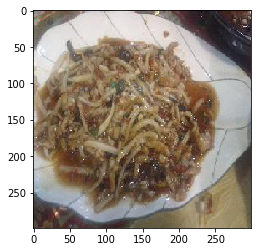

In [163]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [164]:
#MTL
prediction = mtl_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:5]]

Yu-Shiang Shredded Pork


array(['Shredded pork', 'Shredded bamboo shoots',
       'Lentinus edodes slices', 'Dried pieces of bean curd',
       'Mutton slices'], dtype='|S42')

In [165]:
#DI-II 
prediction = di_ii_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:5]]

Yu-Shiang Shredded Pork


array(['Shredded pork', 'Black fungus', 'Julienned carrot',
       'Shredded pepper', 'Minced green onion'], dtype='|S42')

##### Kung Pao Chicken

(3_2)Minced_green_onion,Groundnut_kernels,Crushed_hot_and_dry_chili,Brunoise_diced_chicken
(10_8)Minced_green_onion,Crushed_hot_and_dry_chili,Brunoise_diced_chicken

In [166]:
dir_images = '../datasets/VireoFood172/images/23/'
img_file = '3_2.jpg'

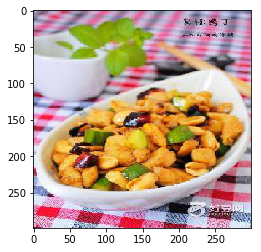

In [167]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [168]:
#MTL
prediction = mtl_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:4]]

Sautéed Sweet Corn with Pine Nuts


array(['Corn kernels', 'Brunoise diced chicken', 'Pine nuts',
       'Brunoise diced cucumber'], dtype='|S42')

In [169]:
#DI-II 
prediction = di_ii_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:4]]

Kung Pao Chicken


array(['Brunoise diced chicken', 'Groundnut kernels',
       'Minced green onion', 'Crushed hot and dry chili'], dtype='|S42')

##### Roast chicken wings

(11_10)Pepper_slices,Chinese_Parsleycoriander,Crushed_hot_and_dry_chili,Hob_blocks_of_potato,Chicken_chunks
(17_13)Hob_blocks_of_carrot,Pepper_slices,Noodles,Hob_blocks_of_potato,Chicken_chunks
(13_21)Pepper_slices,Hob_blocks_of_potato,Chicken_chunks

(15_28)Pepper_slices,Hob_blocks_of_potato,Chicken_chunks

In [223]:
dir_images = '../datasets/VireoFood172/images/25/'
img_file = '11_10.jpg'

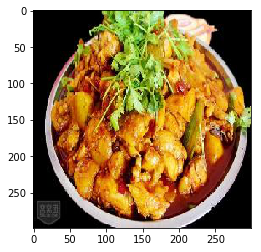

In [224]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [225]:
#MTL
prediction = mtl_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:5]]

Saute Spicy Chicken


array(['Chicken chunks', 'Chinese Parsleycoriander',
       'Hob blocks of potato', 'Bullfrog', 'Garlic clove'], dtype='|S42')

In [226]:
#DI-II 
prediction = di_ii_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:5]]

Saute Spicy Chicken


array(['Hob blocks of potato', 'Chinese Parsleycoriander',
       'Brunoise diced chicken', 'Chicken chunks',
       'Crushed hot and dry chili'], dtype='|S42')

##### Roast Leeks

(2_26)Black_sesame,Chives,Hot_and_dry_pepper_powder,Chili_saurce

(14_5)Chives,Hot_and_dry_pepper_powder,Chili_saurce

In [179]:
dir_images = '../datasets/VireoFood172/images/125/'
img_file = '14_5.jpg'

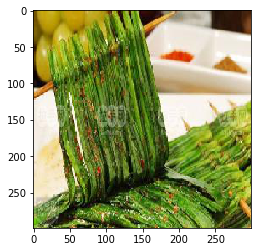

In [180]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [181]:
#MTL
prediction = mtl_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:7]]

Roast leek


array(['Chives', 'Chili saurce', 'Hot and dry pepper powder',
       'Black sesame', 'Green vegetables', 'Parsley', 'Crushed garlic'],
      dtype='|S42')

In [182]:
#DI-II 
prediction = di_ii_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:7]]

Roast leek


array(['Chives', 'Chili saurce', 'Hot and dry pepper powder',
       'Black sesame', 'Parsley', 'Green vegetables',
       'Chinese Parsleycoriander'], dtype='|S42')

##### Beef Kebabs

(9_44)Green_vegetables,Beef_chunks

(7_15)Beef_chunks,Hob_blocks_of_potato,Chili_powder

(6_16)Minced_green_onion,Beef_chunks,Chili_powder

In [191]:
dir_images = '../datasets/VireoFood172/images/61/'
img_file = '9_44.jpg'

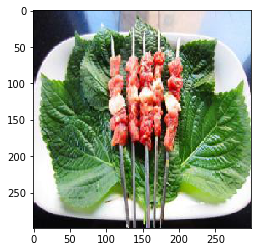

In [192]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [193]:
#MTL
prediction = mtl_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:7]]

Beef Kebabs


array(['Beef chunks', 'Green vegetables', 'Crushed pepper',
       'Minced green onion', 'Garlic clove', 'Black sesame',
       'Chili saurce'], dtype='|S42')

In [194]:
#DI-II 
prediction = di_ii_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:7]]

Beef Kebabs


array(['Beef chunks', 'Chili saurce', 'Green vegetables',
       'Minced green onion', 'Salad dressing', 'Tomato sclices',
       'Parsley'], dtype='|S42')

##### Deep fried shrump

(1_23)Chinese_Parsleycoriander,Fresh_Shrimp,Garlic_clove

(3_36)Seared_green_onion,Fresh_Shrimp

(9_3)Chinese_Parsleycoriander,Fresh_Shrimp,Crushed_hot_and_dry_chili

In [203]:
dir_images = '../datasets/VireoFood172/images/53/'
img_file = '3_36.jpg'

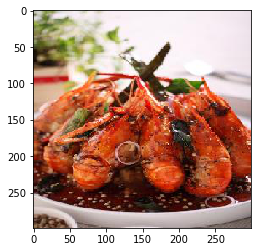

In [204]:
img = image.load_img(dir_images+img_file,target_size=(299,299,3))
img = image.img_to_array(img)
img = img/255
plt.imshow(img)
img = np.expand_dims(img,axis=0)

In [205]:
#MTL
prediction = mtl_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:7]]

Spicy shrump 


array(['Chinese Parsleycoriander', 'Fresh Shrimp', 'Garlic clove',
       'Crushed hot and dry chili', 'Seared green onion',
       'Hot and dry pepper', 'Chili oil'], dtype='|S42')

In [206]:
#DI-II 
prediction = di_ii_model.predict(img)
SL_prediction = prediction[0][0]
ML_prediction = prediction[1][0]

print(dish_labels[SL_prediction.argmax()])
np.array(ingredient_labels)[ML_prediction.argsort()[::-1][:7]]

Spicy crayfish


array(['Chinese Parsleycoriander', 'Crushed hot and dry chili',
       'Minced green onion', 'Crushed pepper', 'Garlic clove',
       'Crushed garlic', 'Cucumber slices'], dtype='|S42')